In [1]:
%cd /home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from adjustText import adjust_text
import re

/home/plent/Documenten/Gitlab/NeuralODEs/jax_neural_odes


### experiments on initialization success rate, convergence properties, and parameter uniqueness

In [2]:
#model information (number of parameters and state variables)
n_parameter={"Borghans_BiophysChem1997":24,
             "Beer_MolBioSystems2014":12,
             "Brannmark_JBC2010":18,
             "Zheng_PNAS2012":62,
             "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":280,
             "Isensee_JCB2018":63,
             "Hass_PONE2017":37,
            "Palani2011":15,
            "Sneyd_PNAS2002":16,
            "Kinetic_glycolysis_assay_model":13,
            "Fujita_SciSignal2010":26,
            "Messiha2013":192,
            "Raia_CancerResearch":45,
            "Weber_BMC2015":53,
            "Crauste_CellSystems2017":16,
            "Fiedler_BMC2016":24,
            "Smallbone2013_SerineBiosynthesis":10,
            "Bruno_JExpBio2016":10,
            "Becker_Science2010":17,
            "Ray2013":20,
            "Chassagnole2002":117,
            "Bertozzi2020":36,
            "Schwen_PONE2014":19,
            "Garde2020":6,
            "Smallbone2011_TrehaloseBiosynthesis":52,
            "Elowitz_Nature2000":22}

n_state_variables={"Borghans_BiophysChem1997":3,
                                "Beer_MolBioSystems2014":4,
             "Brannmark_JBC2010":9,
             "Zheng_PNAS2012":15,
             "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":95,
             "Isensee_JCB2018":25,
             "Hass_PONE2017":9,
                  "Palani2011":5,
                  "Sneyd_PNAS2002":6,
                  "Kinetic_glycolysis_assay_model":12,
                  "Fujita_SciSignal2010":26,
                  "Messiha2013":28,
                  "Raia_CancerResearch":14,
                  "Weber_BMC2015":7,
                  "Crauste_CellSystems2017":5,
                  "Fiedler_BMC2016":6,
                  "Smallbone2013_SerineBiosynthesis":2,
                  "Bruno_JExpBio2016":6,
                  "Becker_Science2010":6,
                  "Ray2013":6,
                  "Chassagnole2002":36,
                  "Bertozzi2020":3,
                  "Schwen_PONE2014":11,
                  "Garde2020":6,
                  "Smallbone2011_TrehaloseBiosynthesis":6,
                  "Elowitz_Nature2000":8}

literature_names={"Borghans_BiophysChem1997":'Borghans et. al (1997)',
                "Beer_MolBioSystems2014":"Beer et. al (2014)",
                "Brannmark_JBC2010":"Brannmark et. al (2010)",
                "Zheng_PNAS2012":"Zheng et. al (2012)",
                "mosbacher2022_mixed_Hog1_phosphorylation_l2v4":"Mosbacher et. al (2023)",
                "Isensee_JCB2018":"Isensee et. al (2018)",
                "Hass_PONE2017":"Hass et. al (2017)",
                  "Palani2011":'Palani et. al (2011)',
                  "Sneyd_PNAS2002":'Sneyd et. al (2002)',
                  "Kinetic_glycolysis_assay_model":'Nitin et. al (2013)',
                  "Fujita_SciSignal2010":'Fujita et. al (2010)',
                  "Messiha2013":'Messiha et. al (2014)',
                  "Raia_CancerResearch":'Raia et. al (2011)',
                  "Weber_BMC2015":'Weber et. al (2015)',
                  "Crauste_CellSystems2017":'Crauste et. al (2017)',
                  "Fiedler_BMC2016":'Fiedler et. al (2016)',
                  "Smallbone2013_SerineBiosynthesis":'Smallbone et. al (2013)',
                  "Bruno_JExpBio2016":'Bruno et. al (2016)',
                  "Becker_Science2010":'Becker et. al (2010)',
                  "Ray2013":'Ray et. al (2013)',
                  "Chassagnole2002":'Chassagnole et. al (2002)',
                  "Bertozzi2020":'Bertozzi et. al (2020)',
                  "Schwen_PONE2014":'Schwen et. al (2015)',
                  "Garde2020":'Garde et. al (2020)',
                  "Smallbone2011_TrehaloseBiosynthesis":'Smallbone et. al (2011)',
                  "Elowitz_Nature2000":'Elowitz et. al (2000)'}

In [3]:
def retrieve_convergence_results(results_dir,file_list):
    # file_list

    loss_dfs={}
    params_dfs={}
    norms_dfs={}
    for file in file_list:
        if "losses" in file:
            loss_data=pd.read_csv(results_dir+file,index_col=0)
            loss_dfs[file]=loss_data
        if "parameters" in file:
            params_data=pd.read_csv(results_dir+file,index_col=0)
            params_dfs[file]=params_data
        if "norms" in file:
            norms_data=pd.read_csv(results_dir+file,index_col=0)
            norms_dfs[file]=norms_data
    return loss_dfs,params_dfs,norms_dfs

def retrieve_success_rate(loss_dfs,model_name):
    """retrieve initializatoin success from loss_dfs"""
    initialization_succes_dict={}
    lb_2=[]
    lb_5=[]
    lb_10=[]
    lb_50=[]
    lb_100=[]
    for bound in list(loss_dfs.keys()):
        if re.search(model_name,bound): 
            # print(bound)
            if re.search("bounds_2.csv",bound):

                loss_df=loss_dfs[bound]
                percentage_succeeded_initializations=len(np.where(loss_df.iloc[0,:]!=-1)[0])/np.shape(loss_df)[1]*100
                lb_2.append(percentage_succeeded_initializations)

            if re.search("bounds_5.csv",bound):
                loss_df=loss_dfs[bound]

                percentage_succeeded_initializations=len(np.where(loss_df.iloc[0,:]!=-1)[0])/np.shape(loss_df)[1]*100
                lb_5.append(percentage_succeeded_initializations)
            if re.search("bounds_10.csv",bound):

                loss_df=loss_dfs[bound]
                percentage_succeeded_initializations=len(np.where(loss_df.iloc[0,:]!=-1)[0])/np.shape(loss_df)[1]*100
                lb_10.append(percentage_succeeded_initializations)

            if re.search("bounds_50.csv",bound):

                loss_df=loss_dfs[bound]
                percentage_succeeded_initializations=len(np.where(loss_df.iloc[0,:]!=-1)[0])/np.shape(loss_df)[1]*100
                lb_50.append(percentage_succeeded_initializations)

            if re.search("bounds_100.csv",bound):

                loss_df=loss_dfs[bound]
                percentage_succeeded_initializations=len(np.where(loss_df.iloc[0,:]!=-1)[0])/np.shape(loss_df)[1]*100
                lb_100.append(percentage_succeeded_initializations)
            initialization_succes_dict['lb_2']=lb_2
            initialization_succes_dict['lb_5']=lb_5
            initialization_succes_dict['lb_10']=lb_10    
            initialization_succes_dict['lb_50']=lb_50
            initialization_succes_dict['lb_100']=lb_100
        
    return initialization_succes_dict

In [4]:
#results directory
model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"

model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)
    model_success_dict[model_name]=retrieve_success_rate(loss_dfs,model_name)

In [5]:
flattened_data = [
    (model, lb, idx + 1, value)  # idx + 1 to get Value_1, Value_2, etc.
    for model, lbs in model_success_dict.items()
    for lb, values in lbs.items()
    for idx, value in enumerate(values)
]
df_init_rate = pd.DataFrame(flattened_data, columns=['Model', 'bounds', 'Value_Index', 'Value'])
df_init_rate = df_init_rate.pivot_table(index=['Model', 'bounds'], columns='Value_Index', values='Value')
# Reset the column names for better readability
df_init_rate.columns = [f'run_{int(col)}' for col in df_init_rate.columns]

# Reset the index to make 'lb' a column
df_init_rate = df_init_rate.reset_index()

df_init_rate.insert(0,"n_parameters",df_init_rate["Model"].apply(lambda x: n_parameter.get(x)))
df_init_rate.insert(0,"n_state_variables",df_init_rate["Model"].apply(lambda x: n_state_variables.get(x)))
df_init_rate.insert(0,"literature_name",df_init_rate["Model"].apply(lambda x: literature_names.get(x)))
df_init_rate['mean_success'] = df_init_rate[['run_1', 'run_2', 'run_3']].mean(axis=1)
df_init_rate['std_success'] = df_init_rate[['run_1', 'run_2', 'run_3']].std(axis=1)
df_init_rate['ratio_s/p']=df_init_rate['n_state_variables']/df_init_rate['n_parameters']

In [6]:


# [int(i) for i in heatmap_data.groupby(by="literature_name")['n_parameters'].unique().values

pivot_df

NameError: name 'pivot_df' is not defined

/tmp/ipykernel_29156/2102753273.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_params=[int(i) for i in temp['n_parameters']]


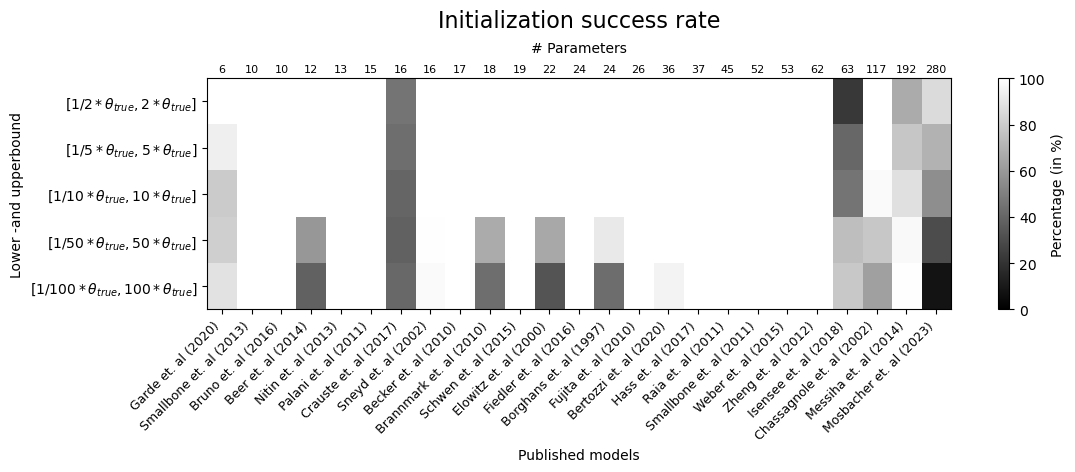

In [7]:
#plotting a heatmap of the mean success

heatmap_data=df_init_rate[['literature_name',"bounds","mean_success","n_parameters"]]
heatmap_data=heatmap_data.sort_values(by="n_parameters")

sorted_columns_parameters=heatmap_data['literature_name'].unique()


temp=pd.DataFrame(heatmap_data.groupby(by="literature_name")['n_parameters'].unique())
temp=temp.sort_values(by="n_parameters")
n_params=[int(i) for i in temp['n_parameters']]


pivot_df = heatmap_data.pivot(index='bounds', columns='literature_name', values='mean_success')
pivot_df=pivot_df[sorted_columns_parameters]
pivot_df=pivot_df.reindex(labels=["lb_2","lb_5","lb_10","lb_50","lb_100"])



# pivot_df.c
fig,ax=plt.subplots(figsize=(12,3))
cax=ax.imshow(pivot_df, cmap='gist_gray', aspect='auto',vmin=0)

fig.colorbar(cax,label='Percentage (in %)')
ax.set_xticks(ticks=np.arange(pivot_df.columns.size), labels=pivot_df.columns,fontsize=9, rotation=45, ha='right')




ax.set_yticks(ticks=np.arange(pivot_df.index.size), labels=["[$1/2*\\theta_{true},2*\\theta_{true}]$","[$1/5*\\theta_{true},5*\\theta_{true}]$",
                                                            "[$1/10*\\theta_{true},10*\\theta_{true}]$",
                                                            "[$1/50*\\theta_{true},50*\\theta_{true}]$","[$1/100*\\theta_{true},100*\\theta_{true}]$"])

# Add number of parameters as text above the columns
ax.text(len(n_params) / 2 - 0.5, -1, '# Parameters', ha='center', va='bottom', fontsize=10, color='black')
ax.text(len(n_params) / 2 - 0.5, -1.5, 'Initialization success rate', ha='center', va='bottom', fontsize=16, color='black')



for i, param in enumerate(n_params):
    ax.text(i, -0.7, f'{param}', ha='center', va='center', fontsize=8, color='black')
ax.set_ylabel("Lower -and upperbound")
ax.set_xlabel("Published models")

fig.savefig("figures/heatmaps_exp1/2208_initialization_success_rate_params.svg",bbox_inches="tight")
fig.savefig("figures/heatmaps_exp1/2208_initialization_success_rate_params.png",bbox_inches="tight")
plt.show()





/tmp/ipykernel_29156/2007899707.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_params=[int(i) for i in temp['n_state_variables']]


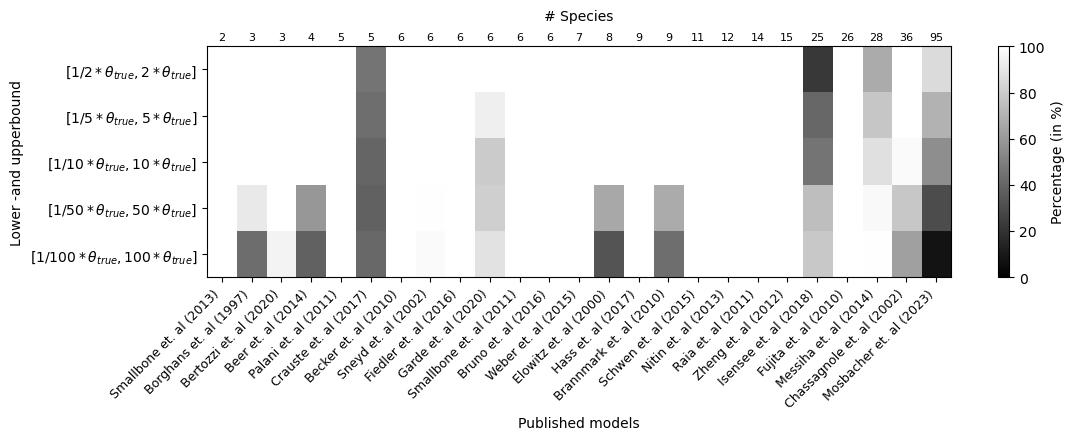

In [8]:
# PLOT2 

heatmap_data=df_init_rate[['literature_name',"bounds","mean_success","n_state_variables"]]

heatmap_data=heatmap_data.sort_values(by="n_state_variables")

sorted_columns_parameters=heatmap_data['literature_name'].unique()


temp=pd.DataFrame(heatmap_data.groupby(by="literature_name")['n_state_variables'].unique())
temp=temp.sort_values(by="n_state_variables")
n_params=[int(i) for i in temp['n_state_variables']]


pivot_df = heatmap_data.pivot(index='bounds', columns='literature_name', values='mean_success')
pivot_df=pivot_df[sorted_columns_parameters]
pivot_df=pivot_df.reindex(labels=["lb_2","lb_5","lb_10","lb_50","lb_100"])
# pivot_df.c
fig,ax=plt.subplots(figsize=(12,3))
cax=ax.imshow(pivot_df, cmap='gist_gray', aspect='auto',vmin=0)

fig.colorbar(cax,label='Percentage (in %)')
ax.set_xticks(ticks=np.arange(pivot_df.columns.size), labels=pivot_df.columns,fontsize=9, rotation=45, ha='right')




ax.set_yticks(ticks=np.arange(pivot_df.index.size), labels=["[$1/2*\\theta_{true},2*\\theta_{true}]$","[$1/5*\\theta_{true},5*\\theta_{true}]$",
                                                            "[$1/10*\\theta_{true},10*\\theta_{true}]$",
                                                            "[$1/50*\\theta_{true},50*\\theta_{true}]$","[$1/100*\\theta_{true},100*\\theta_{true}]$"])

# Add number of parameters as text above the columns
ax.text(len(n_params) / 2 - 0.5, -1, '# Species', ha='center', va='bottom', fontsize=10, color='black')

for i, param in enumerate(n_params):
    ax.text(i, -0.7, f'{param}', ha='center', va='center', fontsize=8, color='black')
ax.set_ylabel("Lower -and upperbound")
ax.set_xlabel("Published models")
# fig.savefig("figures/heatmaps_exp1/2208_initialization_success_rate_species.svg",bbox_inches="tight")
# fig.savefig("figures/heatmaps_exp1/2208_initialization_success_rate_species.png",bbox_inches="tight")
plt.show()

In [9]:
heatmap_data.groupby(["literature_name","bounds"]).mean().loc['Garde et. al (2020)']
heatmap_data[heatmap_data['literature_name']=='Garde et. al (2020)']

,literature_name,bounds,mean_success,n_state_variables
55,Garde et. al (2020),lb_10,79.666667,6
58,Garde et. al (2020),lb_5,93.666667,6
59,Garde et. al (2020),lb_50,81.000000,6
56,Garde et. al (2020),lb_100,88.500000,6
57,Garde et. al (2020),lb_2,100.000000,6


### experiment of the improvement of the loss w.r.t to the initialization

In [10]:
def retrieve_final_loss(loss_dfs):
    """Retrieves a percentage of the succesfull final losses (threshold<0.001)"""
    lb_02=[]
    lb_05=[]
    lb_10=[]
    lb_50=[]
    lb_100=[]


    final_loss_dict={}

    for i in list(loss_dfs.keys()):
        lb_02_run=[]
        lb_05_run=[]
        lb_10_run=[]
        lb_50_run=[]
        lb_100_run=[]
        


        if re.search("bounds_2.csv",i):
            temp=loss_dfs[i]
            for k in range(np.shape(temp)[1]):
                final_loss=list(temp.iloc[:,k].dropna())
                if len(final_loss)>0:
                    final_loss=final_loss[-1]
                    lb_02_run.append(final_loss)
        
            lb_02_run=np.array(lb_02_run)
            lb_02_run=np.sum(np.abs(lb_02_run)<=1e-3)
            lb_02.append(lb_02_run)

        if re.search("bounds_5.csv",i):
            temp=loss_dfs[i]
            for k in range(np.shape(temp)[1]):
                final_loss=list(temp.iloc[:,k].dropna())
                if len(final_loss)>0:
                    final_loss=final_loss[-1]
                    
                    lb_05_run.append(final_loss)


            lb_05_run=np.array(lb_05_run)
            lb_05_run=np.sum(np.abs(lb_05_run)<=1e-3)
            lb_05.append(lb_05_run)

        if re.search("bounds_10.csv",i):
            temp=loss_dfs[i]
            for k in range(np.shape(temp)[1]):
                final_loss=list(temp.iloc[:,k].dropna())
                if len(final_loss)>0:
                    final_loss=final_loss[-1]
                    lb_10_run.append(final_loss)
        
            lb_10_run=np.array(lb_10_run)
            lb_10_run=np.sum(np.abs(lb_10_run)<=1e-3)
            lb_10.append(lb_10_run)

        if re.search("bounds_50.csv",i):
            temp=loss_dfs[i]
            for k in range(np.shape(temp)[1]):
                final_loss=list(temp.iloc[:,k].dropna())
                if len(final_loss)>0:
                    final_loss=final_loss[-1]
                    lb_50_run.append(final_loss)
        
        
            lb_50_run=np.array(lb_50_run)
            lb_50_run=np.sum(np.abs(lb_50_run)<=1e-3)
            lb_50.append(lb_50_run)

        if re.search("bounds_100.csv",i):
            temp=loss_dfs[i]
            for k in range(np.shape(temp)[1]):
                final_loss=list(temp.iloc[:,k].dropna())
                if len(final_loss)>0:
                    final_loss=final_loss[-1]
                    lb_100_run.append(final_loss)
                    
            lb_100_run=np.array(lb_100_run)
            lb_100_run=np.sum(np.abs(lb_100_run)<1e-3)
            lb_100.append(lb_100_run)

    final_loss_dict['lb_2']=lb_02
    final_loss_dict['lb_5']=lb_05
    final_loss_dict['lb_10']=lb_10
    final_loss_dict['lb_50']=lb_50
    final_loss_dict['lb_100']=lb_100
    return final_loss_dict



In [11]:

file_name_model='Elowitz_Nature2000_losses_id_lhs_N=100run_1bounds_10.csv'


model_success_dict_final_loss={}

# loop over model names from directories in results
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)
    model_success_dict_final_loss[model_name]=retrieve_final_loss(loss_dfs)
    

In [12]:
flattened_data = [
    (model, lb, idx + 1, value)  # idx + 1 to get Value_1, Value_2, etc.
    for model, lbs in model_success_dict_final_loss.items()
    for lb, values in lbs.items()
    for idx, value in enumerate(values)
]
final_loss_df = pd.DataFrame(flattened_data, columns=['Model', 'bounds', 'Value_Index', 'Value'])
final_loss_df = final_loss_df.pivot_table(index=['Model', 'bounds'], columns='Value_Index', values='Value')
# Reset the column names for better readability
final_loss_df.columns = [f'run_{int(col)}' for col in final_loss_df.columns]

# Reset the index to make 'lb' a column
final_loss_df = final_loss_df.reset_index()

final_loss_df.insert(0,"n_parameters",final_loss_df["Model"].apply(lambda x: n_parameter.get(x)))
final_loss_df.insert(0,"n_state_variables",final_loss_df["Model"].apply(lambda x: n_state_variables.get(x)))
final_loss_df.insert(0,"literature_name",final_loss_df["Model"].apply(lambda x: literature_names.get(x)))
final_loss_df['mean_success'] = final_loss_df[['run_1', 'run_2', 'run_3']].mean(axis=1)
final_loss_df['std_success'] = final_loss_df[['run_1', 'run_2', 'run_3']].std(axis=1)
final_loss_df['ratio_s/p']=final_loss_df['n_state_variables']/final_loss_df['n_parameters']
# final_loss_df=final_loss_df.drop("run_4",axis=1)

/tmp/ipykernel_29156/1066633771.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  n_params=[int(i) for i in temp['n_parameters']]


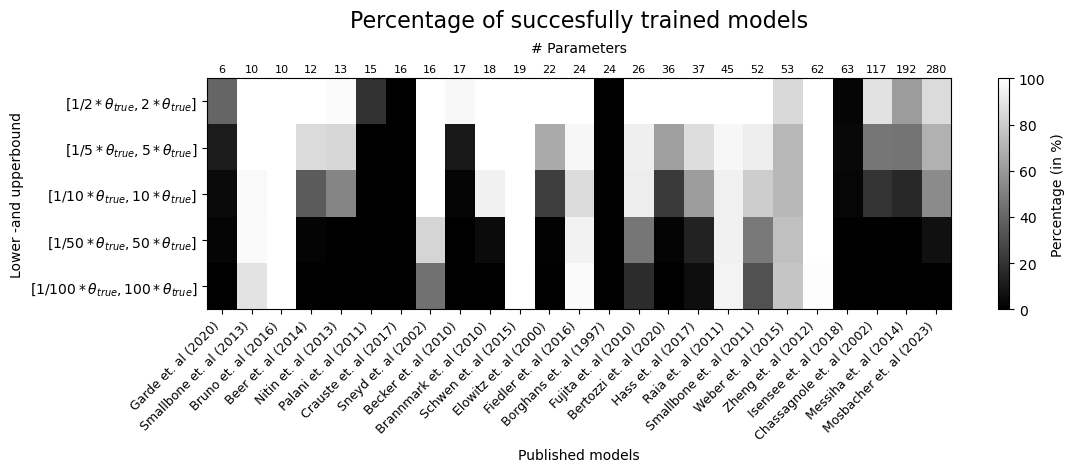

In [13]:
heatmap_data=final_loss_df[['literature_name',"bounds","mean_success","n_parameters"]]
heatmap_data=heatmap_data.sort_values(by="n_parameters")
sorted_columns_parameters=heatmap_data['literature_name'].unique()


temp=pd.DataFrame(heatmap_data.groupby(by="literature_name")['n_parameters'].unique())
temp=temp.sort_values(by="n_parameters")
n_params=[int(i) for i in temp['n_parameters']]


pivot_df = heatmap_data.pivot(index='bounds', columns='literature_name', values='mean_success')
pivot_df=pivot_df[sorted_columns_parameters]
pivot_df=pivot_df.reindex(labels=["lb_2","lb_5","lb_10","lb_50","lb_100"])



# pivot_df.c
fig,ax=plt.subplots(figsize=(12,3))
cax=ax.imshow(pivot_df, cmap='gist_gray', aspect='auto',vmin=0)

fig.colorbar(cax,label='Percentage (in %)')
ax.set_xticks(ticks=np.arange(pivot_df.columns.size), labels=pivot_df.columns,fontsize=9, rotation=45, ha='right')




ax.set_yticks(ticks=np.arange(pivot_df.index.size), labels=["[$1/2*\\theta_{true},2*\\theta_{true}]$","[$1/5*\\theta_{true},5*\\theta_{true}]$",
                                                            "[$1/10*\\theta_{true},10*\\theta_{true}]$",
                                                            "[$1/50*\\theta_{true},50*\\theta_{true}]$","[$1/100*\\theta_{true},100*\\theta_{true}]$"])

# Add number of parameters as text above the columns
ax.text(len(n_params) / 2 - 0.5, -1, '# Parameters', ha='center', va='bottom', fontsize=10, color='black')
ax.text(len(n_params) / 2 - 0.5, -1.5, 'Percentage of succesfully trained models', ha='center', va='bottom', fontsize=16, color='black')



for i, param in enumerate(n_params):
    ax.text(i, -0.7, f'{param}', ha='center', va='center', fontsize=8, color='black')
ax.set_ylabel("Lower -and upperbound")
ax.set_xlabel("Published models")

fig.savefig("figures/heatmaps_exp1/2808_successful_models_percentage_parameters.svg",bbox_inches="tight")
fig.savefig("figures/heatmaps_exp1/2808_successful_models_percentage_parameters.png",bbox_inches="tight")

In [23]:



np.array(pivot_df.columns.to_list())[np.where(pivot_df.iloc[3,:]==0)]

pivot_df

literature_name,Garde et. al (2020),Smallbone et. al (2013),Bruno et. al (2016),Beer et. al (2014),Nitin et. al (2013),Palani et. al (2011),Crauste et. al (2017),Sneyd et. al (2002),Becker et. al (2010),Brannmark et. al (2010),...,Bertozzi et. al (2020),Hass et. al (2017),Raia et. al (2011),Smallbone et. al (2011),Weber et. al (2015),Zheng et. al (2012),Isensee et. al (2018),Chassagnole et. al (2002),Messiha et. al (2014),Mosbacher et. al (2023)
bounds,,,,,,,,,,,,,,,,,,,,,
lb_2,39.666667,100.000000,100.0,100.000000,98.333333,19.666667,0.0,100.000000,97.000000,100.000000,...,99.666667,100.000000,100.000000,100.000000,84.666667,100.0,2.000000,88.333333,61.000000,85.666667
lb_5,10.666667,99.666667,100.0,85.666667,84.000000,0.333333,0.0,100.000000,9.666667,100.000000,...,62.333333,86.333333,96.666667,92.666667,71.666667,100.0,3.333333,46.333333,45.666667,69.333333
lb_10,4.000000,97.333333,100.0,35.666667,52.000000,0.000000,0.0,100.000000,2.333333,94.333333,...,23.000000,61.666667,94.333333,80.333333,72.000000,100.0,2.666667,20.000000,15.666667,54.333333
lb_50,2.000000,97.666667,100.0,1.666667,0.000000,0.000000,0.0,83.333333,0.000000,4.333333,...,1.666667,13.333333,94.333333,48.000000,75.333333,100.0,0.666667,0.500000,0.000000,6.500000
lb_100,0.000000,89.000000,100.0,0.000000,0.000000,0.000000,0.0,44.333333,0.000000,0.000000,...,0.333333,5.666667,95.000000,32.000000,77.000000,99.0,0.000000,0.000000,0.000000,0.333333


### looking at different models with out-of-ordinary behavior
We look at garde, beer, borghans, nitin, palani, crauste, becker, elowitz, isensee

In [15]:
from scipy.stats import gstd
from statistics import geometric_mean



def geometric_mean(loss_df):
    """geometric mean loss dataframe"""
    mean=[]
    for i in range(np.shape(loss_df)[0]):
        loss_df_i=loss_df[i,:
        ]
        loss_df_i=loss_df_i[~np.isnan(loss_df_i)]
        loss_df_i=loss_df_i[loss_df_i!=-1]
        geometric_mean_i=2**np.mean(np.log2(loss_df_i))

        mean.append(geometric_mean_i)
    return mean





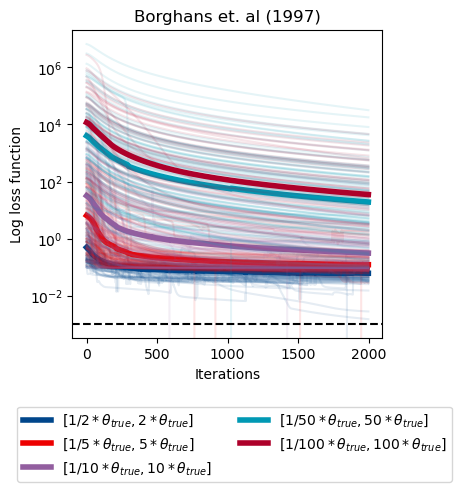

In [534]:
bounds=["bounds_2.csv","bounds_5.csv","bounds_10.csv","bounds_50.csv","bounds_100.csv"]
colors=["#00468BFF","#ED0000FF","#925E9FFF","#0099B4FF","#AD002AFF"]

bounds_legend_name=["[$1/2*\\theta_{true},2*\\theta_{true}]$","[$1/5*\\theta_{true},5*\\theta_{true}]$",
                                                            "[$1/10*\\theta_{true},10*\\theta_{true}]$",
                                                            "[$1/50*\\theta_{true},50*\\theta_{true}]$","[$1/100*\\theta_{true},100*\\theta_{true}]$"]
# model_names_subset=[]
# model_names_subset=['Garde2020','Becker_Science2010',"Kinetic_glycolysis_assay_model",'Palani2011',"Crauste_CellSystems2017","Elowitz_Nature2000","Isensee_JCB2018"]
# model_names_subset=["Kinetic_glycolysis_assay_model"]
# model_names_subset=['Beer_MolBioSystems2014']
# model_names_subset=['Palani2011']
model_names_subset=['Crauste_CellSystems2017']
model_names_subset=['Borghans_BiophysChem1997']

# model_names_subset=['Isensee_JCB2018']
for model_name in model_names_subset:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


    fig,ax=plt.subplots(figsize=(4,4))

    for k,bound in enumerate(bounds):
        for key in list(loss_dfs.keys()):
            if "run_2" in key and bound in key:
                loss_df_bound=np.array(loss_dfs[key])

                # # Identify the parameter indices where no failures occurred (i.e., where loss is not -1)
                # The result is a list of column indices (parameters) where no failures are recorded.

                params_with_no_fails=np.where(loss_df_bound!=-1)[1]
                for i in params_with_no_fails:
                    temp=loss_df_bound[:,i]

                    temp2=temp[~np.isnan(temp)]

                    if len(temp2)>0 and np.abs(temp2[-1])<0.001:
                        temp[np.isnan(temp)]=0.001
                    
                    loss_df_bound[:,i]=temp

                mean=geometric_mean(loss_df_bound)
                
                ax.plot(loss_df_bound,c=colors[k],alpha=0.1)
                ax.plot(mean,c=colors[k],linewidth=4,label=bounds_legend_name[k])

    plt.axhline(1e-3,linestyle="--",c="black")
    ax.set_ylabel("Log loss function")
    ax.set_yscale('log')
    ax.set_xlabel("Iterations")
    ax.set_title(literature_names[model_name])
    # plt.ylim(0.001,8)            
    # fig.legend(bbox_to_anchor=(0.8, 1),loc="upper left")
    ax.legend(loc='upper left', bbox_to_anchor=(-0.2, -0.2),
           ncol=2,fontsize=10)
    # fig.tight_layout()
    # fig.show()
    save_model="figures/"+model_name+"_loss_plots"

    plt.savefig(save_model+".png",bbox_inches="tight")
    plt.savefig(save_model+".svg",bbox_inches="tight")

### Visualize some timeseries plots of strnnge behaving models

In [492]:
# a simple sbml model

from source.load_sbml.sbml_load import *
from source.load_sbml.sbml_model import SBMLModel

filepath = (
      "models/sbml_models/working_models/Crauste_CellSystems2017.xml"
)


model = SBMLModel(filepath)
S=model._get_stoichiometric_matrix()
JaxKmodel = jax.jit(model.get_kinetic_model())
params = get_global_parameters(model.model)
params = {**model.local_params, **params}



ts=jnp.linspace(0,15,1000)
ts2=jnp.linspace(0,15,10)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys2=JaxKmodel(ts=ts2,y0=model.y0,params=params)
# plt.plot(ys)
ys=pd.DataFrame(ys,columns=model.species_names)
ys2=pd.DataFrame(ys2,columns=model.species_names)



17:07:11,077 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
17:07:11,079 - source.load_sbml.sbml_model - INFO - Model loaded.
17:07:11,079 - source.load_sbml.sbml_model - INFO -  number of species: 5
17:07:11,079 - source.load_sbml.sbml_model - INFO -  number of reactions: 12
17:07:11,080 - source.load_sbml.sbml_model - INFO -  number of global parameters: 16
17:07:11,080 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
17:07:11,081 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 0
17:07:11,081 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 4


Text(0.5, 1.0, 'Crauste et. al (2017)')

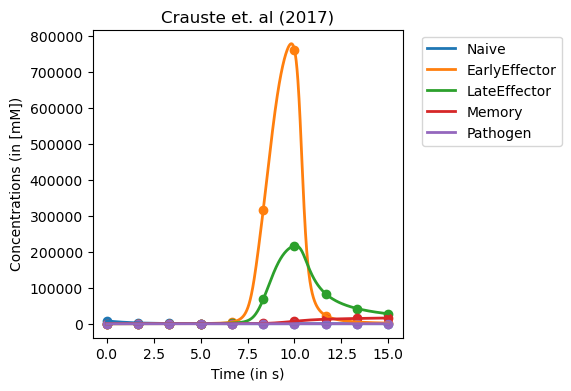

In [493]:
fig,ax=plt.subplots(figsize=(4,4))
for species in ys.columns:
    ax.plot(ts,ys[species],label=species,linewidth=2)
    ax.scatter(ts2,ys2[species])

ax.legend(loc="upper left",bbox_to_anchor=(1.04,1))
ax.set_ylabel("Concentrations (in [mM])")
ax.set_xlabel("Time (in s)")
ax.set_title("Crauste et. al (2017)")


In [494]:
loss_dfs

{'Borghans_BiophysChem1997_losses_id_lhs_N=100run_3bounds_100.csv':         0    1             2             3    4    5         6    7    8    9  \
 0    -1.0 -1.0  4.628688e+06  89461.101194 -1.0 -1.0  2.643867 -1.0 -1.0 -1.0   
 1     NaN  NaN  4.610072e+06  88986.223541  NaN  NaN  2.631879  NaN  NaN  NaN   
 2     NaN  NaN  4.590586e+06  88489.518439  NaN  NaN  2.619337  NaN  NaN  NaN   
 3     NaN  NaN  4.570230e+06  87971.114886  NaN  NaN  2.606243  NaN  NaN  NaN   
 4     NaN  NaN  4.549014e+06  87431.246538  NaN  NaN  2.592603  NaN  NaN  NaN   
 ...   ...  ...           ...           ...  ...  ...       ...  ...  ...  ...   
 1995  NaN  NaN  2.922621e+04      5.267702  NaN  NaN  0.094104  NaN  NaN  NaN   
 1996  NaN  NaN  2.919866e+04      5.262871  NaN  NaN  0.094103  NaN  NaN  NaN   
 1997  NaN  NaN  2.917115e+04      5.258046  NaN  NaN  0.094102  NaN  NaN  NaN   
 1998  NaN  NaN  2.914367e+04      5.253227  NaN  NaN  0.094101  NaN  NaN  NaN   
 1999  NaN  NaN  2.911623e+04  

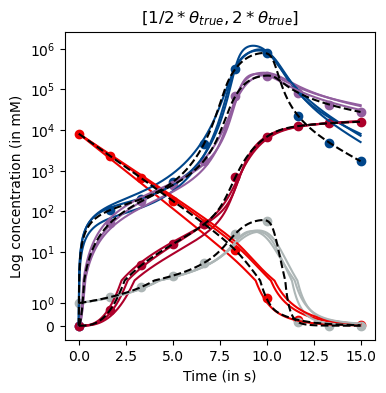

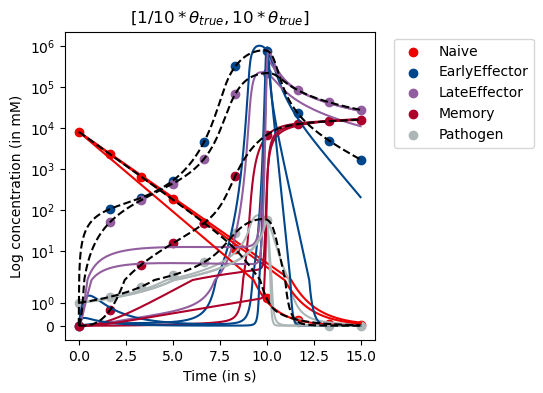

In [495]:
model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"
model_names=['Crauste_CellSystems2017']
model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


example_params=params_dfs['Crauste_CellSystems2017_parameters_id_lhs_N=100run_1bounds_2.csv']
example_loss=loss_dfs['Crauste_CellSystems2017_losses_id_lhs_N=100run_1bounds_2.csv']
indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:3]
indices=[str(i) for i in indices]
# example_params=example_params.loc[indices]
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,15,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Naive'],c="#ED0000FF")
    ax.plot(ts,ys['EarlyEffector'],c="#00468BFF")
    ax.plot(ts,ys['LateEffector'],c="#925E9FFF")
    ax.plot(ts,ys['Memory'],c="#AD002AFF")
    ax.plot(ts,ys['Pathogen'],c="#ADB6B6FF")
    # LateEffector Memory


ts=jnp.linspace(0,15,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Naive'],c="black",linestyle="--")
ax.plot(ts,ys['EarlyEffector'],c="black",linestyle="--")
ax.plot(ts,ys['LateEffector'],c="black",linestyle="--")
ax.plot(ts,ys['Memory'],c="black",linestyle="--")
ax.plot(ts,ys['Pathogen'],c="black",linestyle="--")


ax.scatter(ts2,ys2['Naive'],c="#ED0000FF",label="Naive")
ax.scatter(ts2,ys2['EarlyEffector'],c="#00468BFF",label="EarlyEffector")
ax.scatter(ts2,ys2['LateEffector'],c="#925E9FFF",label="LateEffector")
ax.scatter(ts2,ys2['Memory'],c="#AD002AFF",label="Memory")
ax.scatter(ts2,ys2['Pathogen'],c="#ADB6B6FF",label="Pathogen")
ax.set_yscale("symlog")
ax.set_ylabel("Log concentration (in mM)")
ax.set_xlabel("Time (in s)")
# ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
ax.set_title("$[1/2*\\theta_{true},2*\\theta_{true}]$")
plt.savefig("figures/Crauste_timseries_ub2.png",bbox_inches="tight")
plt.savefig("figures/Crauste_timseries_ub2.svg",bbox_inches="tight")


model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"
model_names=['Crauste_CellSystems2017']
model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)


example_params=params_dfs['Crauste_CellSystems2017_parameters_id_lhs_N=100run_1bounds_10.csv']
example_loss=loss_dfs['Crauste_CellSystems2017_losses_id_lhs_N=100run_1bounds_10.csv']
indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:3]
indices=[str(i) for i in indices]
# example_params=example_params.loc[indices]
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,15,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Naive'],c="#ED0000FF")
    ax.plot(ts,ys['EarlyEffector'],c="#00468BFF")
    ax.plot(ts,ys['LateEffector'],c="#925E9FFF")
    ax.plot(ts,ys['Memory'],c="#AD002AFF")
    ax.plot(ts,ys['Pathogen'],c="#ADB6B6FF")
    # LateEffector Memory


ts=jnp.linspace(0,15,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Naive'],c="black",linestyle="--")
ax.plot(ts,ys['EarlyEffector'],c="black",linestyle="--")
ax.plot(ts,ys['LateEffector'],c="black",linestyle="--")
ax.plot(ts,ys['Memory'],c="black",linestyle="--")
ax.plot(ts,ys['Pathogen'],c="black",linestyle="--")


ax.scatter(ts2,ys2['Naive'],c="#ED0000FF",label="Naive")
ax.scatter(ts2,ys2['EarlyEffector'],c="#00468BFF",label="EarlyEffector")
ax.scatter(ts2,ys2['LateEffector'],c="#925E9FFF",label="LateEffector")
ax.scatter(ts2,ys2['Memory'],c="#AD002AFF",label="Memory")
ax.scatter(ts2,ys2['Pathogen'],c="#ADB6B6FF",label="Pathogen")
ax.set_yscale("symlog")
ax.set_ylabel("Log concentration (in mM)")
ax.set_xlabel("Time (in s)")
ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
ax.set_title("$[1/10*\\theta_{true},10*\\theta_{true}]$")
plt.savefig("figures/Crauste_timseries_ub10.png",bbox_inches="tight")
plt.savefig("figures/Crauste_timseries_ub10.svg",bbox_inches="tight")

In [182]:
model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"
model_names=['Crauste_CellSystems2017']
model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)

# plt.plot(loss_dfs['Crauste_CellSystems2017_losses_id_lhs_N=100run_1bounds_100.csv'],c='red')

17:32:41,126 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
17:32:41,127 - source.load_sbml.sbml_model - INFO - Model loaded.
17:32:41,127 - source.load_sbml.sbml_model - INFO -  number of species: 3
17:32:41,128 - source.load_sbml.sbml_model - INFO -  number of reactions: 8
17:32:41,128 - source.load_sbml.sbml_model - INFO -  number of global parameters: 24
17:32:41,129 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
17:32:41,129 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 0
17:32:41,129 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 1


Text(0.5, 1.0, 'Borghans et. al (1997)')

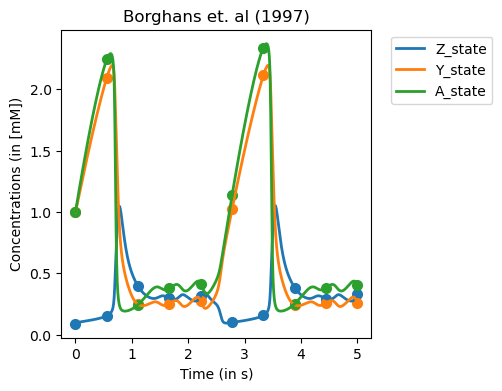

In [521]:
filepath = (
      "models/sbml_models/working_models/Borghans_BiophysChem1997.xml"
)


model = SBMLModel(filepath)
S=model._get_stoichiometric_matrix()
JaxKmodel = model.get_kinetic_model()
JaxKmodel = jax.jit(JaxKmodel)
params = get_global_parameters(model.model)
params = {**model.local_params, **params}



ts=jnp.linspace(0,5,1000)
ts2=jnp.linspace(0,5,10)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys2=JaxKmodel(ts=ts2,y0=model.y0,params=params)
# plt.plot(ys)
ys=pd.DataFrame(ys,columns=model.species_names)
ys2=pd.DataFrame(ys2,columns=model.species_names)

fig,ax=plt.subplots(figsize=(4,4))
for species in ys.columns:
    ax.plot(ts,ys[species],label=species,linewidth=2)
    ax.scatter(ts2,ys2[species],linewidth=2)


ax.legend(loc="upper left",bbox_to_anchor=(1.04,1))
ax.set_ylabel("Concentrations (in [mM])")
ax.set_xlabel("Time (in s)")
ax.set_title("Borghans et. al (1997)")

In [522]:
model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"
model_names=['Borghans_BiophysChem1997']
model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)



example_loss=loss_dfs['Borghans_BiophysChem1997_losses_id_lhs_N=100run_1bounds_2.csv']
# plt.plot(example_loss,c='red')




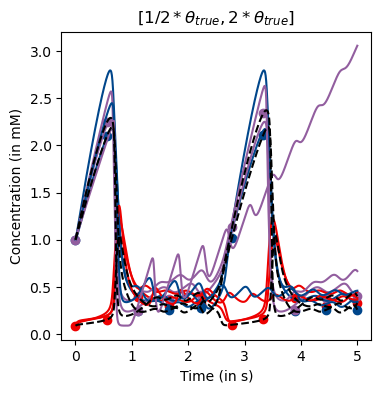

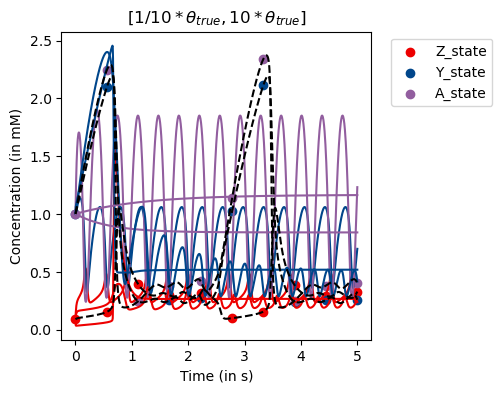

In [524]:
example_params=params_dfs['Borghans_BiophysChem1997_parameters_id_lhs_N=100run_1bounds_2.csv']
example_loss=loss_dfs['Borghans_BiophysChem1997_losses_id_lhs_N=100run_1bounds_2.csv']


indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:3]
indices=[str(i) for i in indices]
# params_dfs
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,5,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Z_state'],c="#ED0000FF")
    ax.plot(ts,ys['Y_state'],c="#00468BFF")
    ax.plot(ts,ys['A_state'],c="#925E9FFF")
    



ts=jnp.linspace(0,5,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Z_state'],c="black",linestyle="--")
ax.plot(ts,ys['Y_state'],c="black",linestyle="--")
ax.plot(ts,ys['A_state'],c="black",linestyle="--")


ax.scatter(ts2,ys2['Z_state'],c="#ED0000FF",label="Z_state")
ax.scatter(ts2,ys2['Y_state'],c="#00468BFF",label="Y_state")
ax.scatter(ts2,ys2['A_state'],c="#925E9FFF",label="A_state")
# ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# ax.set_yscale("symlog")
ax.set_ylabel("Concentration (in mM)")
ax.set_xlabel("Time (in s)")
ax.set_title("$[1/2*\\theta_{true},2*\\theta_{true}]$")
plt.savefig("figures/Borghans_timseries_ub2.png",bbox_inches="tight")
plt.savefig("figures/Borghans_timseries_ub2.svg",bbox_inches="tight")


example_params=params_dfs['Borghans_BiophysChem1997_parameters_id_lhs_N=100run_1bounds_10.csv']
example_loss=loss_dfs['Borghans_BiophysChem1997_losses_id_lhs_N=100run_1bounds_10.csv']


indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:3]
indices=[str(i) for i in indices]
# params_dfs
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,5,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Z_state'],c="#ED0000FF")
    ax.plot(ts,ys['Y_state'],c="#00468BFF")
    ax.plot(ts,ys['A_state'],c="#925E9FFF")


ts=jnp.linspace(0,5,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Z_state'],c="black",linestyle="--")
ax.plot(ts,ys['Y_state'],c="black",linestyle="--")
ax.plot(ts,ys['A_state'],c="black",linestyle="--")


ax.scatter(ts2,ys2['Z_state'],c="#ED0000FF",label="Z_state")
ax.scatter(ts2,ys2['Y_state'],c="#00468BFF",label="Y_state")
ax.scatter(ts2,ys2['A_state'],c="#925E9FFF",label="A_state")
ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# ax.set_yscale("symlog")
ax.set_ylabel("Concentration (in mM)")
ax.set_xlabel("Time (in s)")
ax.set_title("$[1/10*\\theta_{true},10*\\theta_{true}]$")
plt.savefig("figures/Borghans_timseries_ub10.png",bbox_inches="tight")
plt.savefig("figures/Borghans_timseries_ub10.svg",bbox_inches="tight")

17:16:26,288 - source.load_sbml.sbml_model - INFO - No internal inconsistencies found
17:16:26,289 - source.load_sbml.sbml_model - INFO - Model loaded.
17:16:26,289 - source.load_sbml.sbml_model - INFO -  number of species: 6
17:16:26,289 - source.load_sbml.sbml_model - INFO -  number of reactions: 8
17:16:26,289 - source.load_sbml.sbml_model - INFO -  number of global parameters: 17
17:16:26,289 - source.load_sbml.sbml_model - INFO -  number of constant boundary metabolites: 0
17:16:26,289 - source.load_sbml.sbml_model - INFO -  number of lambda function definitions: 0
17:16:26,290 - source.load_sbml.sbml_model - INFO -  number of assignment rules: 3


Text(0.5, 1.0, 'Borghans et. al (1997)')

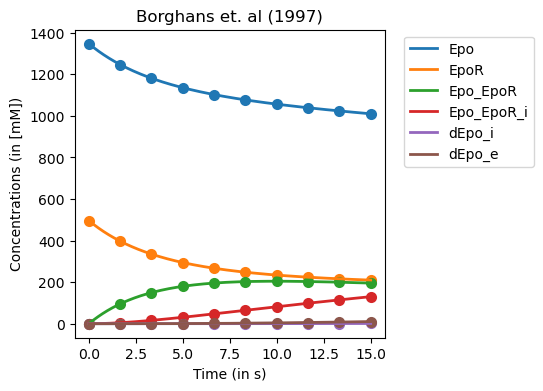

In [508]:
filepath = (
      "models/sbml_models/working_models/Becker_Science2010.xml"
)


model = SBMLModel(filepath)
S=model._get_stoichiometric_matrix()
JaxKmodel = model.get_kinetic_model()
JaxKmodel = jax.jit(JaxKmodel)
params = get_global_parameters(model.model)
params = {**model.local_params, **params}



ts=jnp.linspace(0,15,1000)
ts2=jnp.linspace(0,15,10)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys2=JaxKmodel(ts=ts2,y0=model.y0,params=params)
# plt.plot(ys)
ys=pd.DataFrame(ys,columns=model.species_names)
ys2=pd.DataFrame(ys2,columns=model.species_names)

fig,ax=plt.subplots(figsize=(4,4))
for species in ys.columns:
    ax.plot(ts,ys[species],label=species,linewidth=2)
    ax.scatter(ts2,ys2[species],linewidth=2)


ax.legend(loc="upper left",bbox_to_anchor=(1.04,1))
ax.set_ylabel("Concentrations (in [mM])")
ax.set_xlabel("Time (in s)")
ax.set_title("Borghans et. al (1997)")

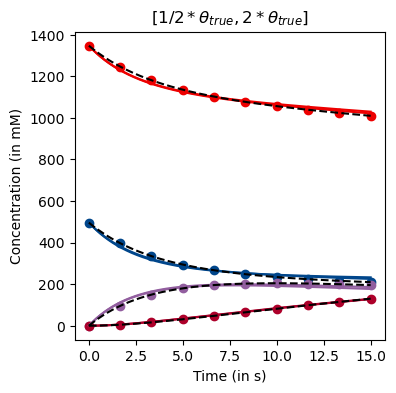

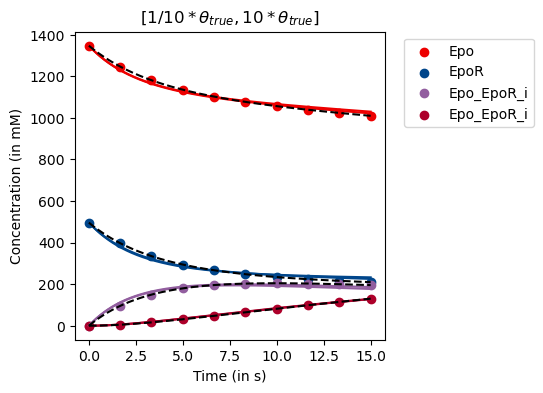

In [516]:
model_names=os.listdir("results/EXP1_initialization_bounds_lhs")

results_dir="results/EXP1_initialization_bounds_lhs/"
model_names=['Becker_Science2010']
model_success_dict={}
for model_name in model_names:
    results_dir="results/EXP1_initialization_bounds_lhs/"+model_name+"/"
    file_list=os.listdir(results_dir)
    loss_dfs,params_dfs,norms_dfs=retrieve_convergence_results(results_dir,file_list)





example_params=params_dfs['Becker_Science2010_parameters_id_lhs_N=100run_1bounds_2.csv']
example_loss=loss_dfs['Becker_Science2010_losses_id_lhs_N=100run_1bounds_2.csv']


indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:2]
indices=[str(i) for i in indices]
# params_dfs
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,15,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Epo'],c="#ED0000FF")
    ax.plot(ts,ys['EpoR'],c="#00468BFF")
    ax.plot(ts,ys['Epo_EpoR'],c="#925E9FFF")
    ax.plot(ts,ys['Epo_EpoR_i'],c="#AD002AFF")



ts=jnp.linspace(0,15,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Epo'],c="black",linestyle="--")
ax.plot(ts,ys['EpoR'],c="black",linestyle="--")
ax.plot(ts,ys['Epo_EpoR'],c="black",linestyle="--")
ax.plot(ts,ys['Epo_EpoR_i'],c="black",linestyle="--")

ax.scatter(ts2,ys2['Epo'],c="#ED0000FF",label="Epo")
ax.scatter(ts2,ys2['EpoR'],c="#00468BFF",label="EpoR")
ax.scatter(ts2,ys2['Epo_EpoR'],c="#925E9FFF",label="Epo_EpoR_i")
ax.scatter(ts2,ys2['Epo_EpoR_i'],c="#AD002AFF",label="Epo_EpoR_i")
# ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# ax.set_yscale("symlog")
ax.set_ylabel("Concentration (in mM)")
ax.set_xlabel("Time (in s)")
ax.set_title("$[1/2*\\theta_{true},2*\\theta_{true}]$")
plt.savefig("figures/Becker_timseries_ub2.png",bbox_inches="tight")
plt.savefig("figures/Becker_timseries_ub2.svg",bbox_inches="tight")


example_params=params_dfs['Becker_Science2010_parameters_id_lhs_N=100run_1bounds_2.csv']
example_loss=loss_dfs['Becker_Science2010_losses_id_lhs_N=100run_1bounds_2.csv']



indices=example_loss.iloc[-1,:].dropna().sort_values().keys()[0:3]
indices=[str(i) for i in indices]
# params_dfs
top5_fits=example_params[indices]

fig,ax=plt.subplots(figsize=(4,4))
for i in range(np.shape(top5_fits)[1]):
    params_test=top5_fits.iloc[:,i].to_dict()
    ts=jnp.linspace(0,15,1000)
    # ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
    ys=JaxKmodel(ts=ts,y0=model.y0,params=params_test)
    ys=pd.DataFrame(ys,columns=model.species_names)
    ax.plot(ts,ys['Epo'],c="#ED0000FF")
    ax.plot(ts,ys['EpoR'],c="#00468BFF")
    ax.plot(ts,ys['Epo_EpoR'],c="#925E9FFF")
    ax.plot(ts,ys['Epo_EpoR_i'],c="#AD002AFF")

ts=jnp.linspace(0,15,1000)
ys=JaxKmodel(ts=ts,y0=model.y0,params=params)
ys=pd.DataFrame(ys,columns=model.species_names)
ax.plot(ts,ys['Epo'],c="black",linestyle="--")
ax.plot(ts,ys['EpoR'],c="black",linestyle="--")
ax.plot(ts,ys['Epo_EpoR'],c="black",linestyle="--")
ax.plot(ts,ys['Epo_EpoR_i'],c="black",linestyle="--")


ax.scatter(ts2,ys2['Epo'],c="#ED0000FF",label="Epo")
ax.scatter(ts2,ys2['EpoR'],c="#00468BFF",label="EpoR")
ax.scatter(ts2,ys2['Epo_EpoR'],c="#925E9FFF",label="Epo_EpoR_i")
ax.scatter(ts2,ys2['Epo_EpoR_i'],c="#AD002AFF",label="Epo_EpoR_i")
ax.legend(bbox_to_anchor=(1.04,1),loc="upper left")
# ax.set_yscale("symlog")
ax.set_ylabel("Concentration (in mM)")
ax.set_xlabel("Time (in s)")
ax.set_title("$[1/10*\\theta_{true},10*\\theta_{true}]$")
plt.savefig("figures/Becker_timseries_ub10.png",bbox_inches="tight")
plt.savefig("figures/Becker_timseries_ub10.svg",bbox_inches="tight")


In [511]:
params_dfs

15